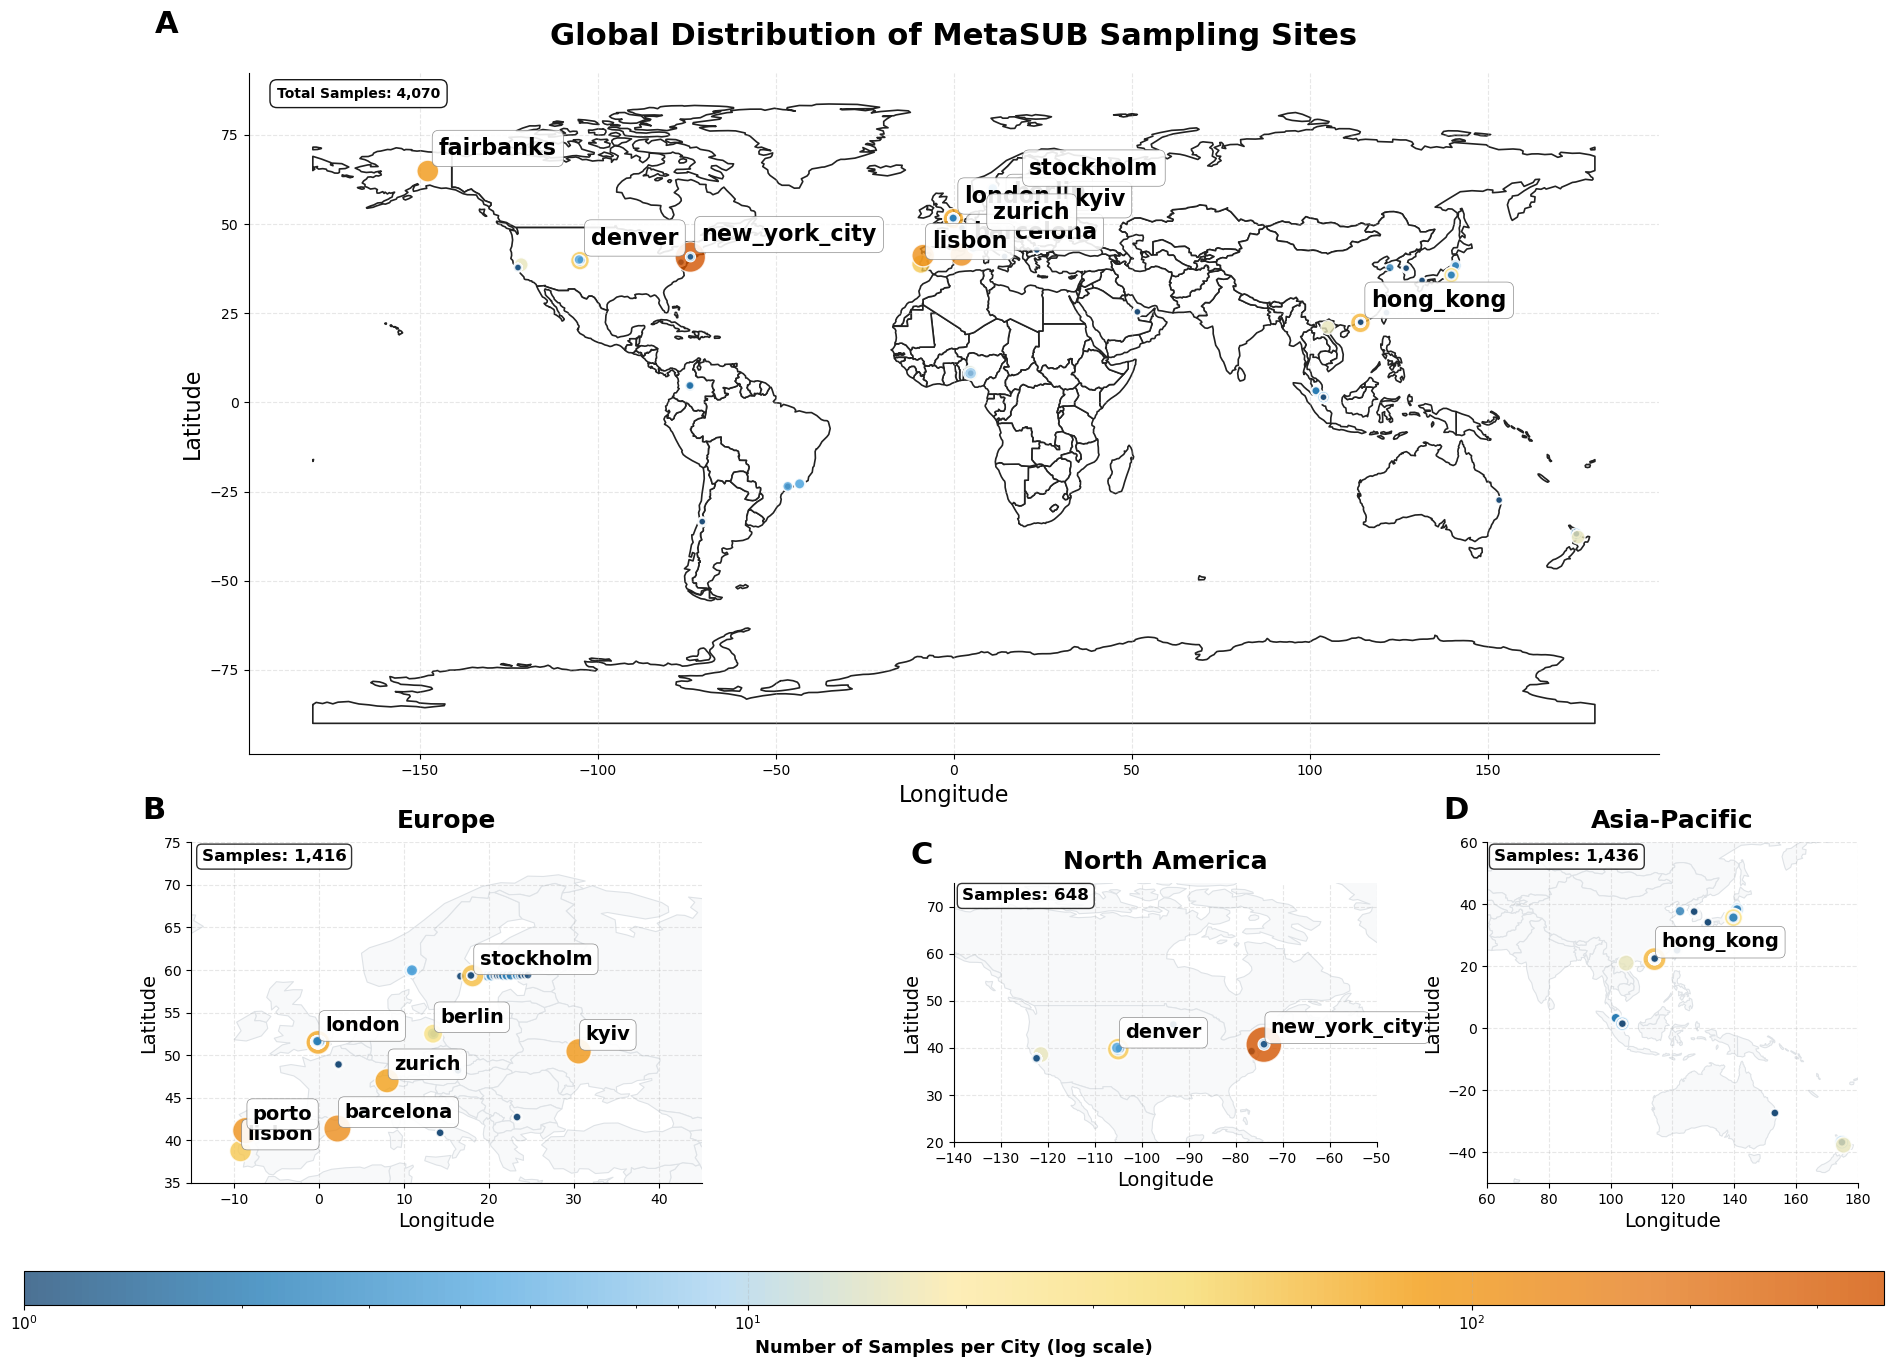


=== MetaSUB Sampling Distribution Summary ===
Total number of cities: 1923
Total number of samples: 4,070

Top 10 cities by sample count:
  new_york_city: 371 samples
  barcelona: 125 samples
  porto: 112 samples
  fairbanks: 97 samples
  kyiv: 97 samples
  zurich: 79 samples
  london: 76 samples
  hong_kong: 64 samples
  stockholm: 58 samples
  denver: 52 samples

Regional distribution:
  Europe: 321 cities, 1,416 samples
  North America: 170 cities, 648 samples
  Asia-Pacific: 1084 cities, 1,436 samples


In [29]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from shapely.geometry import Point
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set publication-ready style
plt.style.use('default')
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 16,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--'
})

# Load data
world = gpd.read_file("/home/chandru/binp37/data/geopandas/ne_110m_admin_0_countries.shp")
rfe_df = pd.read_csv("/home/chandru/binp37/results/metasub/metasub_training_testing_data.csv")

# Prepare city data
city_counts = rfe_df.groupby(['city', 'latitude', 'longitude']).size().reset_index()
city_counts.columns = ['city', 'latitude', 'longitude', 'sample_count']
geometry = [Point(xy) for xy in zip(city_counts['longitude'], city_counts['latitude'])]
cities_gdf = gpd.GeoDataFrame(city_counts, geometry=geometry, crs="EPSG:4326")

# Enhanced color scheme for publication
colors_list = ['#1f4e79', '#2980b9', '#5dade2', '#aed6f1', '#fdeaa7', '#f7dc6f', '#f39c12', '#e67e22', '#d35400']
custom_cmap = LinearSegmentedColormap.from_list('publication_cmap', colors_list, N=256)
norm = colors.LogNorm(vmin=cities_gdf['sample_count'].min(), vmax=cities_gdf['sample_count'].max())

# Create figure with improved layout
fig = plt.figure(figsize=(24, 16))
gs = fig.add_gridspec(3, 3, 
                     width_ratios=[2, 1, 1], 
                     height_ratios=[2, 1, 0.1],
                     wspace=0.15, hspace=0.25)

label_threshold = 25  # Threshold for labeling cities

def plot_region(ax, region_gdf, title, xlim, ylim, label_offset=0.5):
    """Enhanced regional plotting function"""
    world.plot(ax=ax, color='#f8f9fa', edgecolor='#dee2e6', linewidth=0.8)
    
    if len(region_gdf) > 0:
        scatter = ax.scatter(region_gdf.geometry.x, region_gdf.geometry.y,
                           s=np.sqrt(region_gdf['sample_count']) * 35,
                           c=region_gdf['sample_count'], 
                           cmap=custom_cmap,
                           alpha=0.8,
                           edgecolor='white', 
                           linewidth=1.2,
                           norm=norm,
                           zorder=5)
        
        # Smart labeling to avoid overlap
        labeled_positions = []
        for idx, row in region_gdf.iterrows():
            if row['sample_count'] > label_threshold:
                x, y = row.geometry.x, row.geometry.y
                
                # Check for nearby labels to avoid overlap
                too_close = False
                for lx, ly in labeled_positions:
                    if abs(x - lx) < label_offset and abs(y - ly) < label_offset:
                        too_close = True
                        break
                
                if not too_close:
                    ax.annotate(row['city'],
                              xy=(x, y),
                              xytext=(5, 5),
                              textcoords='offset points',
                              fontsize=14,  # Slightly smaller label font size
                              fontweight='bold',
                              ha='left', va='bottom',
                              bbox=dict(boxstyle="round,pad=0.3", 
                                      facecolor="white", 
                                      edgecolor="gray", 
                                      alpha=0.9,
                                      linewidth=0.5),
                              zorder=10)
                    labeled_positions.append((x, y))
    
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_title(title, fontsize=18, fontweight='bold', pad=10)
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Latitude', fontsize=14)
    
    return scatter if len(region_gdf) > 0 else None

# 1. Main World Map (spans 2x2 grid)
ax_world = fig.add_subplot(gs[0, :])

# Plot world map
world.plot(ax=ax_world, color='#ffffff', edgecolor='#222222', linewidth=1.2)

# Plot cities with enhanced styling
scatter_world = ax_world.scatter(cities_gdf.geometry.x, cities_gdf.geometry.y,
                               s=np.sqrt(cities_gdf['sample_count']) * 25,
                               c=cities_gdf['sample_count'], 
                               cmap=custom_cmap,
                               alpha=0.8,
                               edgecolor='white', 
                               linewidth=1.0,
                               norm=norm,
                               zorder=5)

# Smart labeling for world map
labeled_positions = []
for idx, row in cities_gdf.iterrows():
    if row['sample_count'] > label_threshold:
        x, y = row.geometry.x, row.geometry.y
        
        # Check for nearby labels to avoid overlap
        too_close = False
        for lx, ly in labeled_positions:
            if abs(x - lx) < 8 and abs(y - ly) < 4:  # Larger threshold for world map
                too_close = True
                break
        
        if not too_close:
            ax_world.annotate(row['city'],
                            xy=(x, y),
                            xytext=(8, 8),
                            textcoords='offset points',
                            fontsize=16,  # Slightly smaller label font size
                            fontweight='bold',
                            ha='left', va='bottom',
                            bbox=dict(boxstyle="round,pad=0.3", 
                                    facecolor="white", 
                                    edgecolor="gray", 
                                    alpha=0.9,
                                    linewidth=0.5),
                            zorder=10)
            labeled_positions.append((x, y))

ax_world.set_title('Global Distribution of MetaSUB Sampling Sites', 
                  fontsize=22, fontweight='bold', pad=20)
ax_world.set_xlabel('Longitude', fontsize=16)
ax_world.set_ylabel('Latitude', fontsize=16)

# Add sample count statistics as text
total_samples = cities_gdf['sample_count'].sum()
total_cities = len(cities_gdf)
ax_world.text(0.02, 0.98, f'Total Samples: {total_samples:,}', 
             transform=ax_world.transAxes, fontsize=10, fontweight='bold',
             verticalalignment='top',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.9))

# 2. Europe (bottom left)
ax_eu = fig.add_subplot(gs[1, 0])
eu_cities = cities_gdf[(cities_gdf['longitude'] >= -15) & (cities_gdf['longitude'] <= 45) & 
                      (cities_gdf['latitude'] >= 35) & (cities_gdf['latitude'] <= 75)]
plot_region(ax_eu, eu_cities, 'Europe', (-15, 45), (35, 75), label_offset=2)

# 3. North America (bottom middle)
ax_na = fig.add_subplot(gs[1, 1])
na_cities = cities_gdf[(cities_gdf['longitude'] >= -140) & (cities_gdf['longitude'] <= -50) & 
                      (cities_gdf['latitude'] >= 20) & (cities_gdf['latitude'] <= 75)]
plot_region(ax_na, na_cities, 'North America', (-140, -50), (20, 75), label_offset=3)

# 4. Asia-Pacific (bottom right)
ax_ap = fig.add_subplot(gs[1, 2])
ap_cities = cities_gdf[(cities_gdf['longitude'] >= 60) & (cities_gdf['longitude'] <= 180) & 
                      (cities_gdf['latitude'] >= -50) & (cities_gdf['latitude'] <= 60)]
plot_region(ax_ap, ap_cities, 'Asia-Pacific', (60, 180), (-50, 60), label_offset=4)

# 5. Enhanced Colorbar (bottom, spanning all columns)
cbar_ax = fig.add_subplot(gs[2, :])
cb = plt.colorbar(scatter_world, cax=cbar_ax, orientation='horizontal', 
                 shrink=0.8, aspect=40, pad=0.02)
cb.set_label('Number of Samples per City (log scale)', fontsize=13, fontweight='bold')
cb.ax.tick_params(labelsize=11)

# Add letter labels for panels
panel_labels = ['A', 'B', 'C', 'D']
axes = [ax_world, ax_eu, ax_na, ax_ap]

for ax, label in zip(axes, panel_labels):
    ax.text(-0.05, 1.05, label, transform=ax.transAxes, 
           fontsize=22, fontweight='bold', va='bottom', ha='right')  # Slightly smaller panel label size

# Add region statistics
regions = [
    ('Europe', eu_cities),
    ('North America', na_cities),
    ('Asia-Pacific', ap_cities)
]

region_axes = [ax_eu, ax_na, ax_ap]

for (region_name, region_data), ax in zip(regions, region_axes):
    if len(region_data) > 0:
        n_cities = len(region_data)
        n_samples = region_data['sample_count'].sum()
        ax.text(0.02, 0.98, f'Samples: {n_samples:,}', 
               transform=ax.transAxes, fontsize=12, fontweight='bold',  # Slightly smaller region stats label size
               verticalalignment='top',
               bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.tight_layout()

# Save with high quality for publication
plt.savefig('/home/chandru/binp37/report/figures/global_sampling_sites.png', 
           dpi=600, bbox_inches='tight', facecolor='white', edgecolor='none')


plt.show()

# Print summary statistics
print("\n=== MetaSUB Sampling Distribution Summary ===")
print(f"Total number of cities: {len(cities_gdf)}")
print(f"Total number of samples: {cities_gdf['sample_count'].sum():,}")
print(f"\nTop 10 cities by sample count:")
top_cities = cities_gdf.nlargest(10, 'sample_count')[['city', 'sample_count']]
for idx, row in top_cities.iterrows():
    print(f"  {row['city']}: {row['sample_count']} samples")

print(f"\nRegional distribution:")
for region_name, region_data in regions:
    if len(region_data) > 0:
        print(f"  {region_name}: {len(region_data)} cities, {region_data['sample_count'].sum():,} samples")

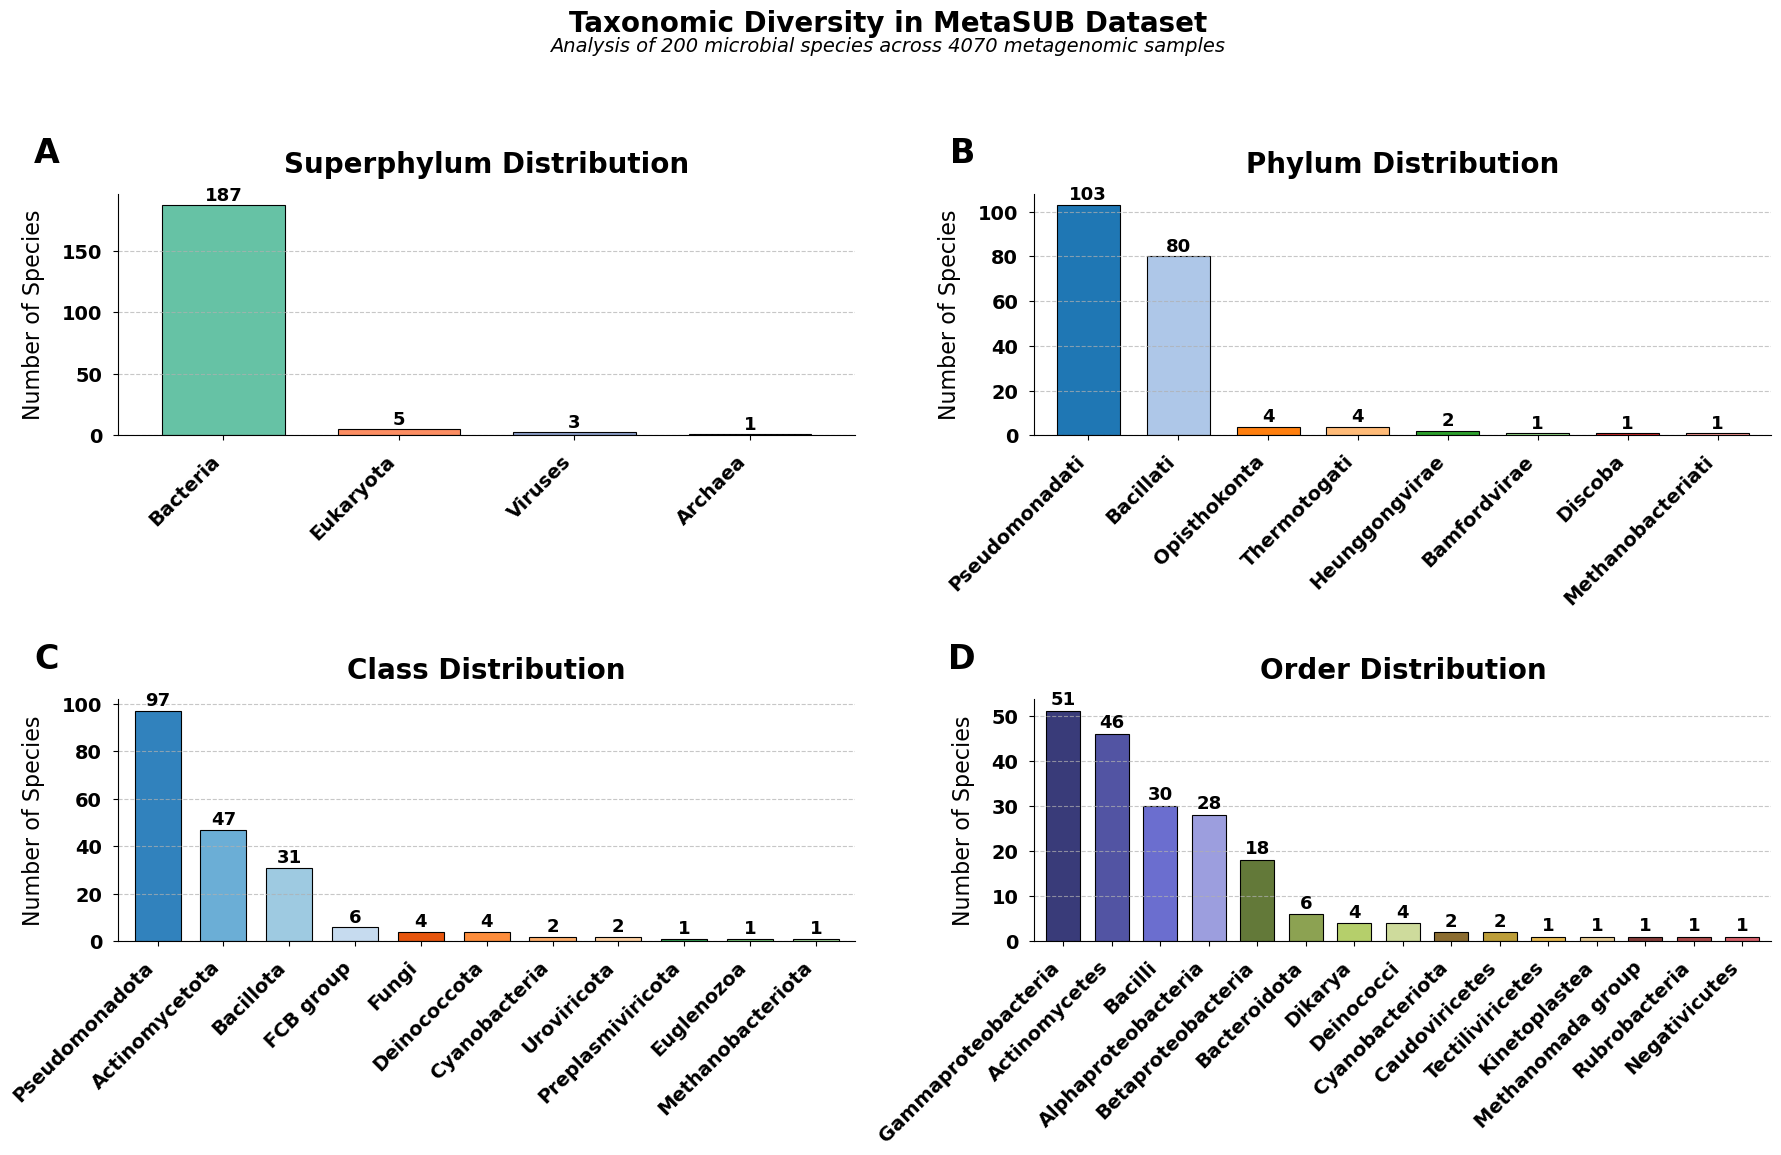


=== MetaSUB Taxonomic Diversity Summary ===
Total number of species analyzed: 196
  cellular organisms: 193 species (98.5%)
  Viruses: 3 species (1.5%)

Top 5 most abundant superphyla:
  1. Bacteria: 187 species
  2. Eukaryota: 5 species
  3. Viruses: 3 species
  4. Archaea: 1 species

Top 5 most abundant phyla:
  1. Pseudomonadati: 103 species
  2. Bacillati: 80 species
  3. Opisthokonta: 4 species
  4. Thermotogati: 4 species
  5. Heunggongvirae: 2 species


In [25]:
#3. Taxonomic and Functional Diversity Summary
#Description: Bar plots or pie charts showing:
#The distribution of major microbial taxa (e.g., bacteria, viruses, archaea).
#Purpose: Highlights the richness of the dataset.


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.gridspec import GridSpec
import warnings
warnings.filterwarnings('ignore')

# Set publication-ready style
plt.style.use('default')
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 16,
    'axes.spines.top': False,
    'axes.spines.right': False
})

# Load data
rfe_df = pd.read_csv("/home/chandru/binp37/results/metasub/metasub_training_testing_data.csv")
microbe_data = rfe_df.iloc[:,:-4]  # Exclude the last 4 columns (metadata)

# Extract species list from column names
species_list = list(microbe_data.columns)

# Load and process taxonomic information
tax_df = pd.read_csv("/home/chandru/binp37/results/metasub/taxonomic_info.csv")
lin_df = tax_df[tax_df['Species'].isin(species_list)].dropna(axis=1, how='all')
lin_df = lin_df.dropna(subset=lin_df.columns[1:7]).iloc[:,:7]

# Rename columns for clarity
lin_df.columns = ['Species', 'Domain', 'Superphylum', 'Phylum', 'Class', 'Order', 'Family']

# Standardize taxonomy names
lin_df['Superphylum'] = lin_df['Superphylum'].replace({
    'Duplodnaviria': 'Viruses', 
    'Varidnaviria': 'Viruses'
})
lin_df['Phylum'] = lin_df['Phylum'].replace({
    'Bacteroidota/Chlorobiota group': 'Bacteroidota', 
    'Methanomada group': 'Methanomada'
})
lin_df['Class'] = lin_df['Class'].replace({
    'Cyanobacteriota/Melainabacteria group': 'Cyanobacteria'
})
lin_df['Order'] = lin_df['Order'].replace({
    'Bacteroidota/Chlorobiota group': 'Bacteroidota'
})

# Create figure with modified layout (2x2 grid)
fig = plt.figure(figsize=(18, 12))
gs = GridSpec(2, 2, figure=fig)

# Create main title for the entire figure
fig.suptitle('Taxonomic Diversity in MetaSUB Dataset', 
             fontsize=20, fontweight='bold', y=0.98)

# Add figure subtitle
plt.figtext(0.5, 0.945, 
            f'Analysis of {len(species_list)} microbial species across {len(rfe_df)} metagenomic samples',
            ha='center', fontsize=14, style='italic')

# Define color palettes for each taxonomic level
superphylum_palette = sns.color_palette("Set2", n_colors=len(lin_df['Superphylum'].unique()))
phylum_palette = sns.color_palette("tab20", n_colors=min(20, len(lin_df['Phylum'].unique())))
class_palette = sns.color_palette("tab20c", n_colors=min(20, len(lin_df['Class'].unique())))

# Function to plot taxonomic counts with enhanced styling
def plot_taxonomic_distribution(df, rank, ax, palette, top_n=None, hide_other=False):
    """Plot taxonomic distribution with publication styling"""
    tax_counts = df[rank].value_counts()
    
    # Handle cases with many categories by grouping less common ones
    if top_n is not None and len(tax_counts) > top_n:
        top_categories = tax_counts.nlargest(top_n).index
        df_plot = df.copy()
        df_plot.loc[~df_plot[rank].isin(top_categories), rank] = 'Other' if not hide_other else np.nan
        tax_counts = df_plot[rank].value_counts()
        if hide_other and 'Other' in tax_counts:
            tax_counts = tax_counts.drop('Other')
    
    # Sort for better visualization
    tax_counts = tax_counts.sort_values(ascending=False)
    
    # Create the bar plot
    bars = tax_counts.plot(kind='bar', ax=ax, color=palette[:len(tax_counts)], 
                          edgecolor='black', linewidth=0.8, width=0.7)
    
    # Enhance styling
    ax.set_title(f'{rank} Distribution', fontsize=20, fontweight='bold', pad=15)
    ax.set_ylabel('Number of Species', fontsize=16, labelpad=12)
    ax.set_xlabel('', fontsize=16)  # Hide x-axis label as it's redundant
    
    # Rotate labels and adjust them for readability
    ax.tick_params(axis='x', rotation=45, labelsize=14, pad=8)
    ax.tick_params(axis='y', labelsize=14, pad=8)
    plt.setp(ax.xaxis.get_majorticklabels(), ha='right', fontsize=14, fontweight='bold')
    plt.setp(ax.yaxis.get_majorticklabels(), fontsize=14, fontweight='bold')
    
    # Add value labels on top of bars
    for i, bar in enumerate(bars.patches):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{int(height)}', ha='center', va='bottom', fontsize=13, 
                fontweight='bold', rotation=0)
    
    # Add grid lines for better readability
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Remove top and right spines
    sns.despine(ax=ax)
    
    return tax_counts

# Create the four taxonomic distribution plots
ax_superphylum = fig.add_subplot(gs[0, 0])
ax_phylum = fig.add_subplot(gs[0, 1])
ax_class = fig.add_subplot(gs[1, 0])
ax_order = fig.add_subplot(gs[1, 1])

# Plot with improved styling and limited to top categories
superphylum_counts = plot_taxonomic_distribution(lin_df, 'Superphylum', ax_superphylum, superphylum_palette)
phylum_counts = plot_taxonomic_distribution(lin_df, 'Phylum', ax_phylum, phylum_palette, top_n=15)
class_counts = plot_taxonomic_distribution(lin_df, 'Class', ax_class, class_palette, top_n=15)
order_counts = plot_taxonomic_distribution(lin_df, 'Order', ax_order, sns.color_palette("tab20b"), top_n=15)

# Add panel labels
panel_positions = [ax_superphylum, ax_phylum, ax_class, ax_order]
panel_labels = ['A', 'B', 'C', 'D']

for ax, label in zip(panel_positions, panel_labels):
    ax.text(-0.08, 1.10, label, transform=ax.transAxes, 
           fontsize=24, fontweight='bold', va='bottom', ha='right')

# Adjust layout and save
plt.tight_layout(rect=[0, 0.02, 1, 0.94])  # Make room for suptitle

# Save with high quality for publication
plt.savefig('/home/chandru/binp37/report/figures/taxonomic_diversity_summary.png', 
           dpi=600, bbox_inches='tight', facecolor='white', edgecolor='none')


plt.show()

# Print summary statistics (kept in the terminal output but not in the figure)
print("\n=== MetaSUB Taxonomic Diversity Summary ===")
print(f"Total number of species analyzed: {len(lin_df)}")

domain_summary = lin_df['Domain'].value_counts().to_dict()
for domain, count in domain_summary.items():
    percentage = (count / len(lin_df)) * 100
    print(f"  {domain}: {count} species ({percentage:.1f}%)")

print("\nTop 5 most abundant superphyla:")
for i, (sp, count) in enumerate(superphylum_counts.head(5).items(), 1):
    print(f"  {i}. {sp}: {count} species")

print("\nTop 5 most abundant phyla:")
for i, (phylum, count) in enumerate(phylum_counts.head(5).items(), 1):
    print(f"  {i}. {phylum}: {count} species")